Importing necessary libraries

In [3]:
import cv2  # For image processing
import numpy as np  # For numerical operations
import os  # For file and directory manipulation
import tensorflow as tf  # For machine learning tasks
import imghdr
import matplotlib.pyplot as plt

In [4]:
# Import TensorFlow
import tensorflow as tf

# List available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

# Iterate over each GPU and set memory growth to True
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
data_dir = 'C:\\Users\\roboc\\Downloads\\archive (15)\\chest_xray\\train'

In [7]:
# Define the list of allowed image extensions
image_exts = ['jpg', 'png', 'jpeg', 'bmp']

# Iterate through each image class directory in the data directory
for image_class in os.listdir(data_dir)[1:]:
    # Iterate through each image in the image class directory
    for image in os.listdir(os.path.join(data_dir, image_class)):
        # Construct the full path to the image
        image_path = os.path.join(data_dir, image_class, image)
        try:
            # Read the image using OpenCV
            img = cv2.imread(image_path)
            
            # Check the image file format using imghdr
            tip = imghdr.what(image_path)
            
            # If the image format is not in the allowed list, remove the image
            if tip not in image_exts:
                os.remove(image_path)
        except Exception as e:
            # If an error occurs during processing, skip the image
            pass   

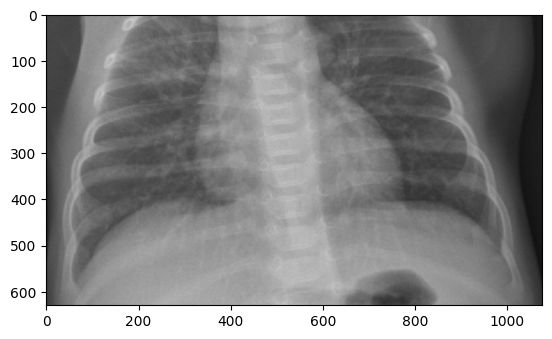

In [8]:
# Assuming 'img' is the image data you want to display and Display the image
plt.imshow(img)

# Show the plot with the image
plt.show()


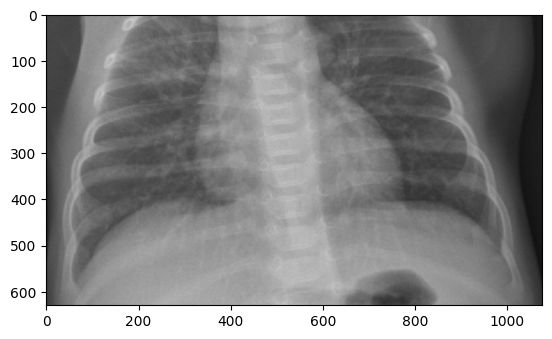

In [9]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

In [10]:
# Load image data from a directory and create a TensorFlow Dataset
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 5232 files belonging to 2 classes.


In [11]:
# Seeing the next Batch
batch = data.as_numpy_iterator().next()

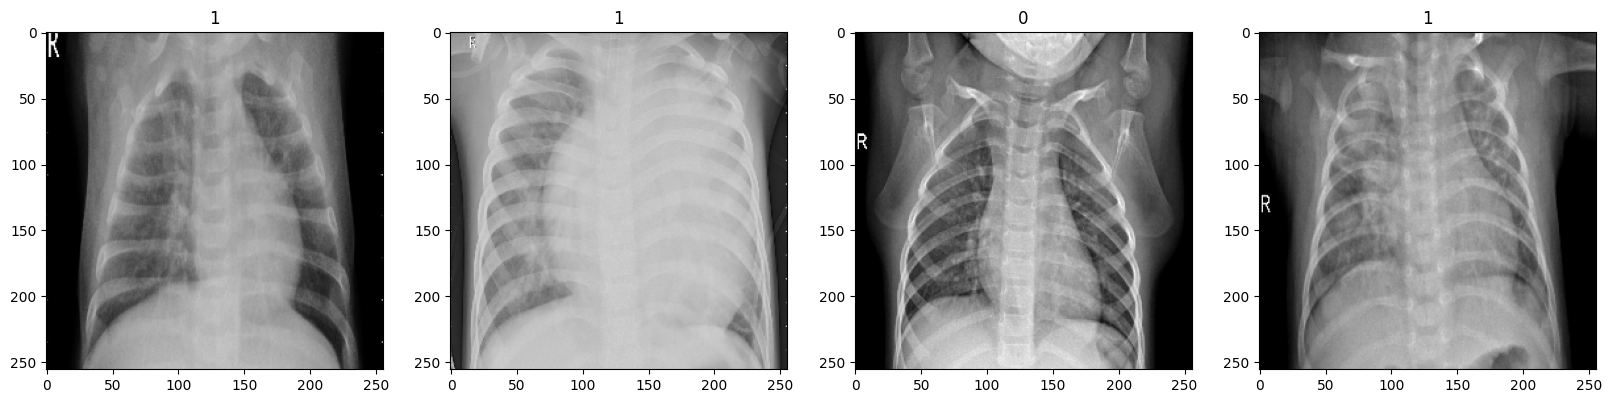

In [34]:
# Printing first 4 batches
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(batch[0][idx]/255)
    ax[idx].title.set_text(batch[1][idx])

In [13]:
data = data.map(lambda x,y : (x/255,y)) # Normalize the image data by scaling pixel values to the range [0, 1]

In [41]:
data.as_numpy_iterator().next()[0][0].min() # Obtain the minimum pixel value of the first image in the dataset

0.0

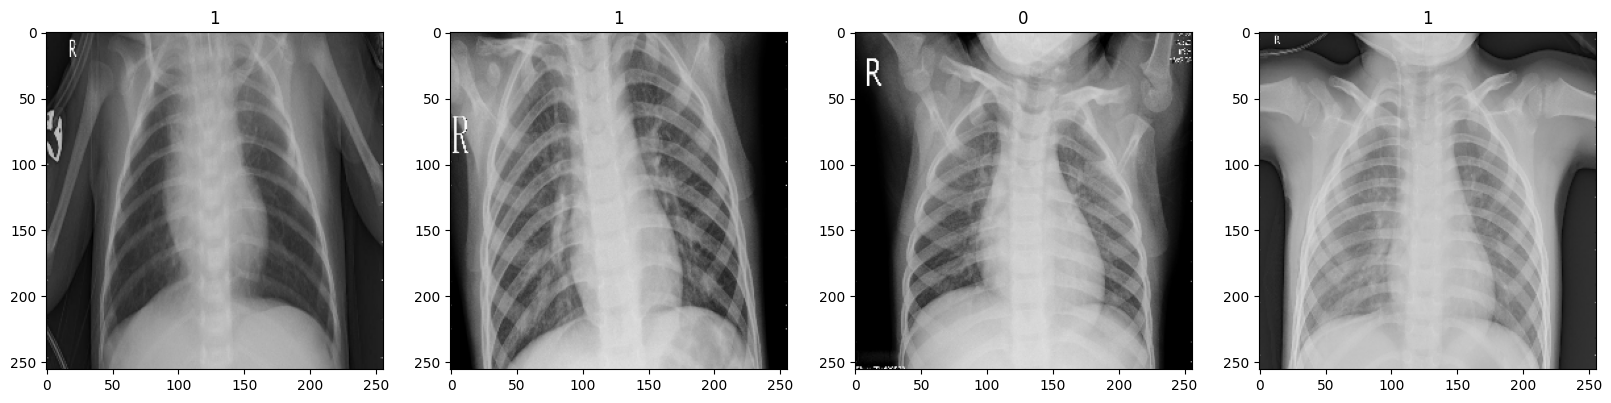

In [42]:
# Create a visualization of a sample of images from the dataset
# Display the first four images along with their corresponding labels

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(data.as_numpy_iterator().next()[0][:4]):
    ax[idx].imshow(data.as_numpy_iterator().next()[0][idx]) # Display the image
    ax[idx].title.set_text(batch[1][idx]) # Set the title as the corresponding label

Split the dataset into training, testing, and validation sets and Calculating the sizes of each set based on specified proportions

In [48]:
train_size = int(len(data)*0.7)+1
test_size=int(len(data)*0.2)+1
val_size = int(len(data)*0.1)

Extract training data from the dataset


In [50]:
train_data = data.take(train_size)
test_data = data.skip(train_size).take(test_size)
val_data = data.skip(train_size+test_size).take(val_size)

In [51]:
import tensorflow as tf
from tensorflow.keras import layers, models

Creating the neural network

In [54]:
# Create a sequential model
model = models.Sequential()

# Add a 2D convolutional layer with 32 filters, each with a 3x3 kernel,
# using ReLU activation function, and input shape of (256, 256, 3)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))

# Add a max pooling layer with a 2x2 pool size
model.add(layers.MaxPooling2D((2, 2)))

# Add another 2D convolutional layer with 64 filters and a 3x3 kernel,
# using ReLU activation function
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Add another max pooling layer
model.add(layers.MaxPooling2D((2, 2)))

# Add a third 2D convolutional layer with 64 filters and a 3x3 kernel,
# using ReLU activation function
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Flatten the output of the convolutional layers
model.add(layers.Flatten())

# Add a fully connected layer with 256 units and ReLU activation
model.add(layers.Dense(256, activation='relu'))

# Add an output layer with a single unit and sigmoid activation function
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model with the Adam optimizer, binary cross-entropy loss function,
# and accuracy as the evaluation metric
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model architecture and parameter counts
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 230400)           

Fitting the model - Epochs(2) , Batching-Active

In [56]:
hist = model.fit(train_data, validation_data=val_data, epochs=2)

Epoch 1/2


115/115 [==============================] - 163s 1s/step - loss: 0.1167 - accuracy: 0.9554 - val_loss: 0.0863 - val_accuracy: 0.9698
Epoch 2/2
115/115 [==============================] - 158s 1s/step - loss: 0.0806 - accuracy: 0.9712 - val_loss: 0.0746 - val_accuracy: 0.9718


In [57]:
hist.history

{'loss': [0.11669399589300156, 0.08060161024332047],
 'accuracy': [0.9554347991943359, 0.971195638179779],
 'val_loss': [0.08629783242940903, 0.07460170984268188],
 'val_accuracy': [0.9697580933570862, 0.9717742204666138]}

In [66]:
# Initialize the metrics
acc = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

# Iterate through the test dataset
for batch in test_data.as_numpy_iterator():
    X_test, y_test = batch
    y_pred = model.predict(X_test)
    
    # Update the metrics
    acc.update_state(y_test, tf.round(y_pred))
    precision.update_state(y_test, tf.round(y_pred))
    recall.update_state(y_test, tf.round(y_pred))

# Get the results
accuracy_result = acc.result().numpy()
precision_result = precision.result().numpy()
recall_result = recall.result().numpy()

# Print the results
print("Accuracy:", accuracy_result)
print("Precision:", precision_result)
print("Recall:", recall_result)

1/1 [==============================] - 0s 273ms/step
Accuracy: 0.9592803
Precision: 0.9831388
Recall: 0.96192896


Saving the created Model

In [67]:
model.save(os.path.join(data_dir,'pneumonia_detector.h5'))


C:\Users\roboc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Loading the model

In [68]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model(os.path.join(data_dir,'pneumonia_detector.h5'))


Performing Image Preprocessing so that it could be fed to the model

In [81]:
dir = "C:\\Users\\roboc\\Downloads\\archive (15)\\chest_xray\\test\\PNEUMONIA"
ima = (os.path.join(dir,"VIRUS-8377377-0001.jpeg"))
imge = cv2.imread(ima)
imge

array([[[68, 68, 68],
        [66, 66, 66],
        [63, 63, 63],
        ...,
        [36, 36, 36],
        [34, 34, 34],
        [32, 32, 32]],

       [[64, 64, 64],
        [63, 63, 63],
        [61, 61, 61],
        ...,
        [36, 36, 36],
        [34, 34, 34],
        [32, 32, 32]],

       [[62, 62, 62],
        [62, 62, 62],
        [63, 63, 63],
        ...,
        [35, 35, 35],
        [33, 33, 33],
        [31, 31, 31]],

       ...,

       [[42, 42, 42],
        [42, 42, 42],
        [42, 42, 42],
        ...,
        [40, 40, 40],
        [40, 40, 40],
        [40, 40, 40]],

       [[42, 42, 42],
        [42, 42, 42],
        [42, 42, 42],
        ...,
        [40, 40, 40],
        [40, 40, 40],
        [40, 40, 40]],

       [[42, 42, 42],
        [42, 42, 42],
        [42, 42, 42],
        ...,
        [40, 40, 40],
        [40, 40, 40],
        [40, 40, 40]]], dtype=uint8)

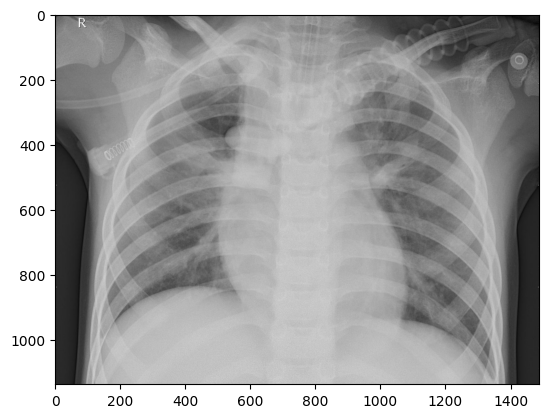

In [83]:
plt.imshow(imge)
plt.show()

In [84]:
img_resized = cv2.resize(imge, (256, 256))
img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
img_normalized = img_gray / 255.0

In [89]:
input_img = np.expand_dims(img_normalized, axis=0)

In [91]:
prediction = loaded_model.predict(input_img)
prediction

1/1 [==============================] - 0s 91ms/step


array([[0.9827596]], dtype=float32)

: 